In [687]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Model Implementation

### Layers

In [688]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [689]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

### Loss function

In [690]:
def loss_function(h, g, x, x_, W, reconstruction_weight = 1):
    l1 = 0.5
    l2 = 0.5
    r1 = reconstruction_weight
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return r1*s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

### Gradient Computation

In [691]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

### Model Class

In [692]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, reconstruction_weight = 1, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W, reconstruction_weight)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([cd, ca])
    
        
            

# Testing

### Signal generation functions

In [693]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


### Currently the built-in families are:

   - Haar (haar)
   - Daubechies (db)
   - Symlets (sym)
   - Coiflets (coif)
   - Biorthogonal (bior)
   - Reverse biorthogonal (rbio)
   - “Discrete” FIR approximation of Meyer wavelet (dmey)
   - Gaussian wavelets (gaus)
   - Mexican hat wavelet (mexh)
   - Morlet wavelet (morl)
   - Complex Gaussian wavelets (cgau)
   - Shannon wavelets (shan)
   - Frequency B-Spline wavelets (fbsp)
   - Complex Morlet wavelets (cmor)


### Print wavelets for a familie

In [694]:
print(pywt.wavelist('coif'))

['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17']


### Select a orthogonal wavelet for testing

In [708]:
w = 'coif1'
wavelet = pywt.Wavelet(w)
print("is orthogonal?",wavelet.orthogonal)
wavelet.dec_len

is orthogonal? True


6

### Signal generation and fiting

In [709]:
x = generate_signal(32, w)

In [710]:

model = Model(6)

In [711]:
model.fit(x, epochs=2000, learning_rate=0.001, good_error=1, reconstruction_weight=10)

Epochs #1: 564.1319701709917 loss
Epochs #2: 368.01288202135373 loss
Epochs #3: 310.4518367800572 loss
Epochs #4: 280.9074407287708 loss
Epochs #5: 261.3210396796649 loss
Epochs #6: 246.07578530084731 loss
Epochs #7: 233.00921360499433 loss
Epochs #8: 221.23157063983126 loss
Epochs #9: 210.38291636290467 loss
Epochs #10: 200.32727438656534 loss
Epochs #11: 191.01547102184978 loss
Epochs #12: 182.42368999708538 loss
Epochs #13: 174.52830448082324 loss
Epochs #14: 167.29794271661885 loss
Epochs #15: 160.69312985678533 loss
Epochs #16: 154.6714907528511 loss
Epochs #17: 149.17048377730717 loss
Epochs #18: 144.155875382422 loss
Epochs #19: 139.58039918279815 loss
Epochs #20: 135.39956763394503 loss
Epochs #21: 131.57231831060005 loss
Epochs #22: 128.06127999394175 loss
Epochs #23: 124.83278288598736 loss
Epochs #24: 121.85670882097352 loss
Epochs #25: 119.10625045338564 loss
Epochs #26: 116.55762651009186 loss
Epochs #27: 114.18978378435546 loss
Epochs #28: 111.98410484075518 loss
Epochs #

Epochs #235: 34.77640751482175 loss
Epochs #236: 34.67222515686783 loss
Epochs #237: 34.56865474268614 loss
Epochs #238: 34.465691031968575 loss
Epochs #239: 34.363328835111666 loss
Epochs #240: 34.2615630129994 loss
Epochs #241: 34.16038847709381 loss
Epochs #242: 34.05980018916869 loss
Epochs #243: 33.95979316123583 loss
Epochs #244: 33.860913379372356 loss
Epochs #245: 33.768996232869135 loss
Epochs #246: 33.67699077548175 loss
Epochs #247: 33.578282274799825 loss
Epochs #248: 33.48646740292325 loss
Epochs #249: 33.39450569073313 loss
Epochs #250: 33.296180311481976 loss
Epochs #251: 33.20463864158534 loss
Epochs #252: 33.11294570578172 loss
Epochs #253: 33.02138636500856 loss
Epochs #254: 32.92319280579499 loss
Epochs #255: 32.83199976184725 loss
Epochs #256: 32.74080913993562 loss
Epochs #257: 32.64342055351736 loss
Epochs #258: 32.55283843391057 loss
Epochs #259: 32.46220690604312 loss
Epochs #260: 32.371776077361936 loss
Epochs #261: 32.27498508981418 loss
Epochs #262: 32.185122

Epochs #470: 19.93234289474878 loss
Epochs #471: 19.893129693129424 loss
Epochs #472: 19.86303675689736 loss
Epochs #473: 19.823864778372734 loss
Epochs #474: 19.793747126903884 loss
Epochs #475: 19.754648425797637 loss
Epochs #476: 19.722177291586114 loss
Epochs #477: 19.68370106323111 loss
Epochs #478: 19.65411249856297 loss
Epochs #479: 19.615686332529783 loss
Epochs #480: 19.58607424034684 loss
Epochs #481: 19.547718325608148 loss
Epochs #482: 19.517999744115137 loss
Epochs #483: 19.489047047452807 loss
Epochs #484: 19.44795793956036 loss
Epochs #485: 19.41940660834009 loss
Epochs #486: 19.38138297249615 loss
Epochs #487: 19.352810598394058 loss
Epochs #488: 19.314922613428443 loss
Epochs #489: 19.278875665430917 loss
Epochs #490: 19.230653631368813 loss
Epochs #491: 19.19382884515488 loss
Epochs #492: 19.15804240888162 loss
Epochs #493: 19.112824650413618 loss
Epochs #494: 19.079599947778554 loss
Epochs #495: 19.0344461080895 loss
Epochs #496: 18.995572196053082 loss
Epochs #497: 

Epochs #694: 12.876730412207662 loss
Epochs #695: 12.84997565015227 loss
Epochs #696: 12.823561573124081 loss
Epochs #697: 12.79730240176357 loss
Epochs #698: 12.780247519174662 loss
Epochs #699: 12.753881160499914 loss
Epochs #700: 12.727584544481113 loss
Epochs #701: 12.716607155967692 loss
Epochs #702: 12.690444636329284 loss
Epochs #703: 12.664320871074642 loss
Epochs #704: 12.647854984582944 loss
Epochs #705: 12.621589181737109 loss
Epochs #706: 12.595753429671547 loss
Epochs #707: 12.570100638185986 loss
Epochs #708: 12.553635522990078 loss
Epochs #709: 12.527888805121098 loss
Epochs #710: 12.5024995750521 loss
Epochs #711: 12.492010687904635 loss
Epochs #712: 12.466411452876919 loss
Epochs #713: 12.441055161529398 loss
Epochs #714: 12.424972541795333 loss
Epochs #715: 12.39970549531089 loss
Epochs #716: 12.37441609427185 loss
Epochs #717: 12.3493755385736 loss
Epochs #718: 12.333618135586118 loss
Epochs #719: 12.308649235651075 loss
Epochs #720: 12.283784639207362 loss
Epochs #7

Epochs #934: 8.89957063311437 loss
Epochs #935: 8.892790047203945 loss
Epochs #936: 8.886322833970999 loss
Epochs #937: 8.872760611133288 loss
Epochs #938: 8.866761979591674 loss
Epochs #939: 8.847253136006062 loss
Epochs #940: 8.840779094667411 loss
Epochs #941: 8.827480110731926 loss
Epochs #942: 8.821198923913835 loss
Epochs #943: 8.802192340533818 loss
Epochs #944: 8.795816111994364 loss
Epochs #945: 8.79008020354577 loss
Epochs #946: 8.773836295058198 loss
Epochs #947: 8.767015006132526 loss
Epochs #948: 8.74684174235981 loss
Epochs #949: 8.741183575007325 loss
Epochs #950: 8.725469205039662 loss
Epochs #951: 8.718673433268316 loss
Epochs #952: 8.700810063552721 loss
Epochs #953: 8.693872676381748 loss
Epochs #954: 8.687355658705886 loss
Epochs #955: 8.671923218182005 loss
Epochs #956: 8.66760052977446 loss
Epochs #957: 8.647830219660491 loss
Epochs #958: 8.641429660955737 loss
Epochs #959: 8.628238443672876 loss
Epochs #960: 8.622175485805695 loss
Epochs #961: 8.60302355092783 lo

Epochs #1158: 7.146328634013956 loss
Epochs #1159: 7.144634923966678 loss
Epochs #1160: 7.138032395516057 loss
Epochs #1161: 7.13650835981005 loss
Epochs #1162: 7.1250366984802085 loss
Epochs #1163: 7.1233425581873 loss
Epochs #1164: 7.124899957810685 loss
Epochs #1165: 7.1152038992136015 loss
Epochs #1166: 7.111747812695636 loss
Epochs #1167: 7.110466628287328 loss
Epochs #1168: 7.103531656478011 loss
Epochs #1169: 7.102566760544782 loss
Epochs #1170: 7.090595587667401 loss
Epochs #1171: 7.0891275230222535 loss
Epochs #1172: 7.090829174138968 loss
Epochs #1173: 7.076260341064596 loss
Epochs #1174: 7.0774907970865435 loss
Epochs #1175: 7.06816378790324 loss
Epochs #1176: 7.0693402761938176 loss
Epochs #1177: 7.072059035157942 loss
Epochs #1178: 7.056664997771512 loss
Epochs #1179: 7.058568500187138 loss
Epochs #1180: 7.04877975464899 loss
Epochs #1181: 7.0509816275906205 loss
Epochs #1182: 7.036134935184443 loss
Epochs #1183: 7.037826955520389 loss
Epochs #1184: 7.0365853094098565 loss

Epochs #1382: 5.842465563862637 loss
Epochs #1383: 5.838775697544245 loss
Epochs #1384: 5.831740015761802 loss
Epochs #1385: 5.82344373068503 loss
Epochs #1386: 5.822780714972216 loss
Epochs #1387: 5.811298734979124 loss
Epochs #1388: 5.8005831957379925 loss
Epochs #1389: 5.801071694418372 loss
Epochs #1390: 5.784985530779868 loss
Epochs #1391: 5.7849765875469545 loss
Epochs #1392: 5.773141574971809 loss
Epochs #1393: 5.773719924983642 loss
Epochs #1394: 5.757615298061825 loss
Epochs #1395: 5.757628062253905 loss
Epochs #1396: 5.7469107071042025 loss
Epochs #1397: 5.747467261376919 loss
Epochs #1398: 5.731612682585301 loss
Epochs #1399: 5.730506130586654 loss
Epochs #1400: 5.719767772895324 loss
Epochs #1401: 5.722931078314657 loss
Epochs #1402: 5.706962428521512 loss
Epochs #1403: 5.707210724965933 loss
Epochs #1404: 5.703109880426973 loss
Epochs #1405: 5.690870178087431 loss
Epochs #1406: 5.687389637810844 loss
Epochs #1407: 5.680414941638274 loss
Epochs #1408: 5.677168873223726 loss

Epochs #1609: 4.617390055094646 loss
Epochs #1610: 4.6164292529928534 loss
Epochs #1611: 4.609488245451007 loss
Epochs #1612: 4.606600796348558 loss
Epochs #1613: 4.6047998015200085 loss
Epochs #1614: 4.597733503735494 loss
Epochs #1615: 4.59556752663335 loss
Epochs #1616: 4.5862735516984126 loss
Epochs #1617: 4.590105187436281 loss
Epochs #1618: 4.576728517146992 loss
Epochs #1619: 4.578465276076405 loss
Epochs #1620: 4.578544755197498 loss
Epochs #1621: 4.567525431510307 loss
Epochs #1622: 4.570869410269738 loss
Epochs #1623: 4.558500942111327 loss
Epochs #1624: 4.557786552581828 loss
Epochs #1625: 4.5509812452012355 loss
Epochs #1626: 4.550649316660416 loss
Epochs #1627: 4.552480727768594 loss
Epochs #1628: 4.539551596089827 loss
Epochs #1629: 4.538815703753252 loss
Epochs #1630: 4.5332514418919265 loss
Epochs #1631: 4.531900970766931 loss
Epochs #1632: 4.530072275168237 loss
Epochs #1633: 4.5223937663321 loss
Epochs #1634: 4.522236361731406 loss
Epochs #1635: 4.5157531286412755 los

Epochs #1831: 4.070682006526943 loss
Epochs #1832: 4.073009586513158 loss
Epochs #1833: 4.066719863616513 loss
Epochs #1834: 4.06919386647077 loss
Epochs #1835: 4.072815876270083 loss
Epochs #1836: 4.065217473094198 loss
Epochs #1837: 4.0628970235094295 loss
Epochs #1838: 4.062145713601491 loss
Epochs #1839: 4.06131589252976 loss
Epochs #1840: 4.064095525886726 loss
Epochs #1841: 4.054728267376026 loss
Epochs #1842: 4.059066881166023 loss
Epochs #1843: 4.050040073632533 loss
Epochs #1844: 4.055324451541222 loss
Epochs #1845: 4.046477034889426 loss
Epochs #1846: 4.048703450959641 loss
Epochs #1847: 4.051908406872187 loss
Epochs #1848: 4.040491984758032 loss
Epochs #1849: 4.0441904201537575 loss
Epochs #1850: 4.0382242265308586 loss
Epochs #1851: 4.039939970323238 loss
Epochs #1852: 4.04316047316872 loss
Epochs #1853: 4.036183475070867 loss
Epochs #1854: 4.036816296557613 loss
Epochs #1855: 4.034971225476432 loss
Epochs #1856: 4.034106020248089 loss
Epochs #1857: 4.037428997211707 loss
E

## Metrics and plot

 ### Reconstruction Error

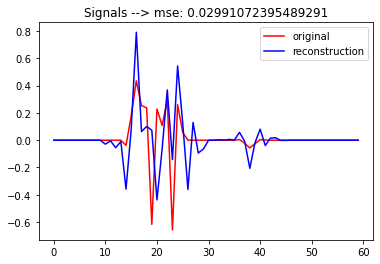

In [712]:
p = model.predict(x)
mse = mean_squared_error(p,x)

plt.plot(np.arange(len(x)), x, c = 'r', label="original")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()
plt.title("Signals -->" + " mse: " + str(mse))
print()

### Wavelets and Scaling functions error

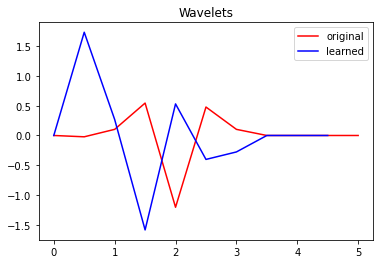

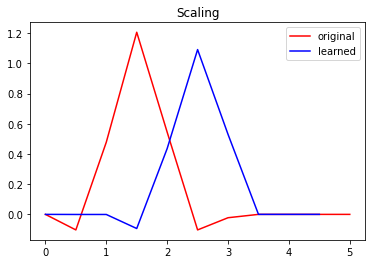

In [713]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet(w).wavefun(level=1)
lo = np.arange(len(ao))
plt.figure(1)
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets")
plt.legend()

plt.figure(2)
plt.title("Scaling")
plt.plot(ao, phi, c = 'r', label="original")
plt.plot(al,phi_d, c='b', label='learned')
plt.legend()


print()

### DWT error

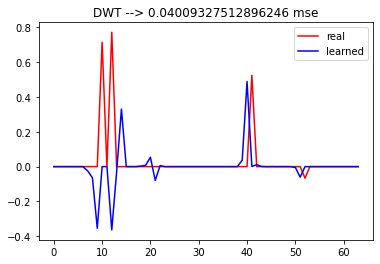

In [714]:

fake_dwt = model.dwt(x)
ca, cd = pywt.dwt(x, wavelet=w)
real_dwt = np.concatenate([cd, ca])

fake_len = len(fake_dwt)
real_len = len(real_dwt)

min_len = min(fake_len, real_len)
real_dwt = real_dwt[:min_len]
fake_dwt = fake_dwt[:min_len]

mse_dwt = mean_squared_error(real_dwt, fake_dwt)
plt.plot(np.arange(min_len), real_dwt, c = 'r', label = 'real')
plt.plot(np.arange(min_len), fake_dwt, c = 'b', label = 'learned')
plt.title("DWT --> " + str(mse_dwt) + " mse")
plt.legend()
print()